# **Import Libraries:**

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# **Load Dataset:**

In [3]:
df = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
df = df[[0, 5]]
df.columns = ['polarity', 'text']
print(df.head())

   polarity                                               text
0         0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1         0  is upset that he can't update his Facebook by ...
2         0  @Kenichan I dived many times for the ball. Man...
3         0    my whole body feels itchy and like its on fire 
4         0  @nationwideclass no, it's not behaving at all....


# **Only Positive and Negative Sentiments:**

In [4]:
df = df[df.polarity != 2]

df['polarity'] = df['polarity'].map({0: 0, 4: 1})

print(df['polarity'].value_counts())

polarity
0    800000
1    800000
Name: count, dtype: int64


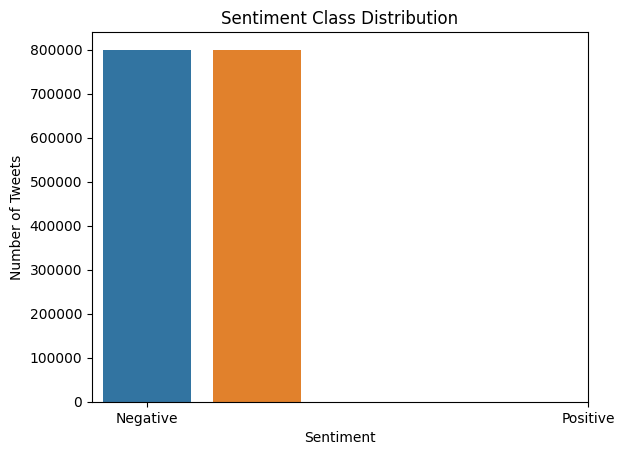

In [5]:
#Sentiment Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt

# If you're using 0 = Negative, 4 = Positive
sns.countplot(data=df, x='polarity')
plt.xticks([0, 4], ['Negative','Positive'])
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

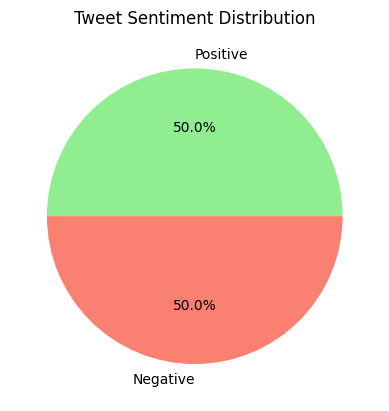

In [6]:
#Bar chart and Pie chart both indicate that there is no class imbalance
df['polarity'].value_counts().plot(
    kind='pie',
    labels=['Positive', 'Negative'] if df['polarity'].nunique() == 2 else ['Negative', 'Neutral', 'Positive'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'salmon', 'skyblue'],
    title='Tweet Sentiment Distribution',
    ylabel=''
)
plt.show()

# **Clean the tweets:**

In [7]:
def clean_text(text):
    return text.lower()

df['clean_text'] = df['text'].apply(clean_text)

print(df[['text', 'clean_text']].head())

                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                          clean_text  
0  @switchfoot http://twitpic.com/2y1zl - awww, t...  
1  is upset that he can't update his facebook by ...  
2  @kenichan i dived many times for the ball. man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


# **Train Test Split:**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['polarity'],
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 1280000
Test size: 320000


In [9]:
print(X_train)

1374558    @jbtaylor with ya. &quot;i'd like a palm pre, ...
1389115    felt the earthquake this afternoon, it seems t...
1137831          ruffles on shirts are like so in, me likey 
790714     pretty bad night into a crappy morning....fml!...
1117911               @dcbriccetti yeah, what a clear view! 
                                 ...                        
259178     this song's middle change just doesn't want to...
1414414                 @officialnjonas good luck with that 
131932              @proudgamertweet i rather average 32370 
671155     pickin up @misstinayao waitin on @sadittysash ...
121958     @ home studying for maths wooot ! im so going ...
Name: clean_text, Length: 1280000, dtype: object


# **Vactorization:**

In [10]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (test):", X_test_tfidf.shape)

TF-IDF shape (train): (1280000, 5000)
TF-IDF shape (test): (320000, 5000)


# **SVM Model:**

In [13]:
svm = LinearSVC(max_iter=1000)
svm.fit(X_train_tfidf, y_train)

y_pred = svm.predict(X_test_tfidf)


# **Performance Metrices:**

# **Classification Report**

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.79528125

Confusion Matrix:
 [[124076  35418]
 [ 30092 130414]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.79      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



# **Confusion Matrix**

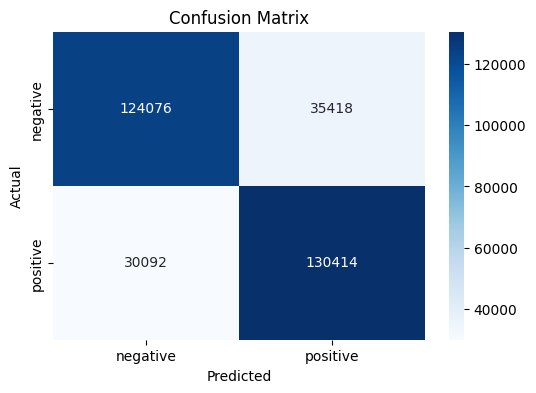

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

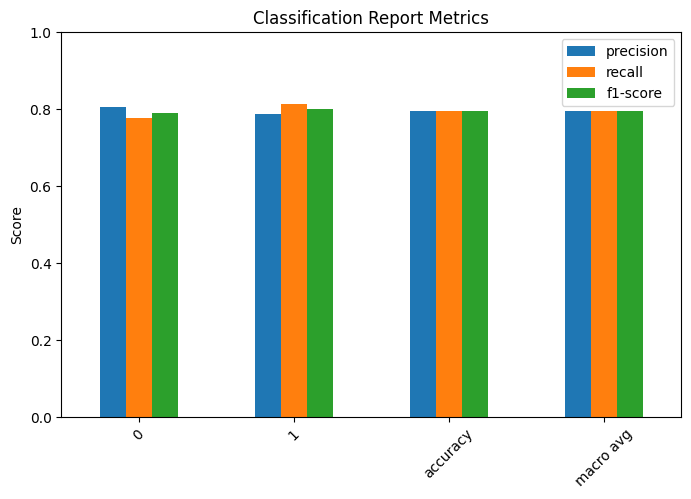

In [17]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.iloc[:-1, :3].plot(kind='bar', figsize=(8,5))
plt.title('Classification Report Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

# **Prediction on sample tweets:**

In [18]:
sample_tweets = ["I love this!", "I hate that!", "It was okay, not great."]
sample_vec = vectorizer.transform(sample_tweets)

print("\nSample Predictions:")
print("SVM:", svm.predict(sample_vec))


Sample Predictions:
SVM: [1 0 1]


# **Save the Model:**

In [22]:
import pickle

with open('tweeter_sentiment.pkl', 'wb') as file:
    pickle.dump(svm, file)

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

print("✅ Model and vectorizer saved successfully.")

✅ Model and vectorizer saved successfully.
